## EDA 对PUBG的探索分析

<img src="https://pmcvariety.files.wordpress.com/2018/04/pubg.jpg?w=1000&h=563&crop=1" alt="PUBG" style="width: 750px;"/>

核心特征:
- [The Killers](#The-Killers)
- [The Runners](#The-Runners)
- [The Drivers](#The-Drivers)
- [The Swimmers](#The-Swimmers)
- [The Healers](#The-Healers)
- [Solos, Duos and Squads](#Solos,-Duos-and-Squads)
- [Correlation](#Pearson-correlation-between-variables)
- [Feature Engineering](#Feature-Engineering)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

In [3]:
train = pd.read_csv('../PUBGData/train_V2.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


- **groupId** - 比赛中队伍的id，如果队伍成员不变，在不同的比赛中，队伍id也会不一样
- **matchId** - 每一场比赛的id
- **assists** - 对敌人造成伤害，但被队友补刀的敌人数量
- **boosts** - 加速道具使用的数量，饮料，肾上腺素，止痛药等
- **damageDealt** - 造成的总伤害，除去自己因不当操作（落地，闭气时间过长等对自己造成的伤害）
- **DBNOs** - 击倒的敌人数量
- **headshotKills** - 爆头杀死的敌人数量
- **heals** - 治疗药品的使用数量
- **killPlace** - 在比赛中杀死敌人数量的排名
- **killPoints** - 杀敌得分，个人理解为白银杀黄金能得到较高的分数，而黄金杀白银得到的分数则较少
- **kills** - 杀死敌人的数量
- **killStreaks** - 短时间内杀死的最多敌人数量，可能理解为几连杀.
- **longestKill** - 杀死敌人的最长距离，但是这项数据有可能引起误导，因为玩家可能会在击倒一个敌人之后开车离开，形成一个很长的杀敌距离
- **maxPlace** - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.(不是很理解这一项，大概是说比赛中的最差排名，但是可能会大于队伍总数，原因是因为该项数据会跳过排名)
- **numGroups** - 比赛中的队伍数量.
- **revives** - 玩家救援队友次数
- **rideDistance** - 交通工具行驶总里程（米）.
- **roadKills** - 杀死车辆内的敌人数量.
- **swimDistance** - 游泳总里程（米）.
- **teamKills** - 杀死队友数量.
- **vehicleDestroys** - 摧毁车辆数目.
- **walkDistance** - 行走总里程（米）.
- **weaponsAcquired** - 捡起的武器数量.
- **winPoints** - 胜利得分，理解为综合评分
- **winPlacePerc** - 预测的目标，获胜的百分位位置，1对应第一名，0对应最后一名，根据maxPlace计算，所以在比赛中可能会有缺失

In [5]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


现在对数据有了一个初步的了解，现在可以深入去探索数据了

## The Killers

<img src="https://i.ytimg.com/vi/rnAeX795Jn0/maxresdefault.jpg" alt="The Killers" style="width: 700px;"/>

In [6]:
print("平均每个人杀了 {:.4f} 个玩家, 99% 的人杀了 {} 个或者更少, 最高的杀敌个数是 {}个.".format(train['kills'].mean(),train['kills'].quantile(0.99), train['kills'].max()))

平均每个人杀了 0.9248 个玩家, 99% 的人杀了 7.0 个或者更少, 最高的杀敌个数是 72个.


对杀敌数目的统计如下：

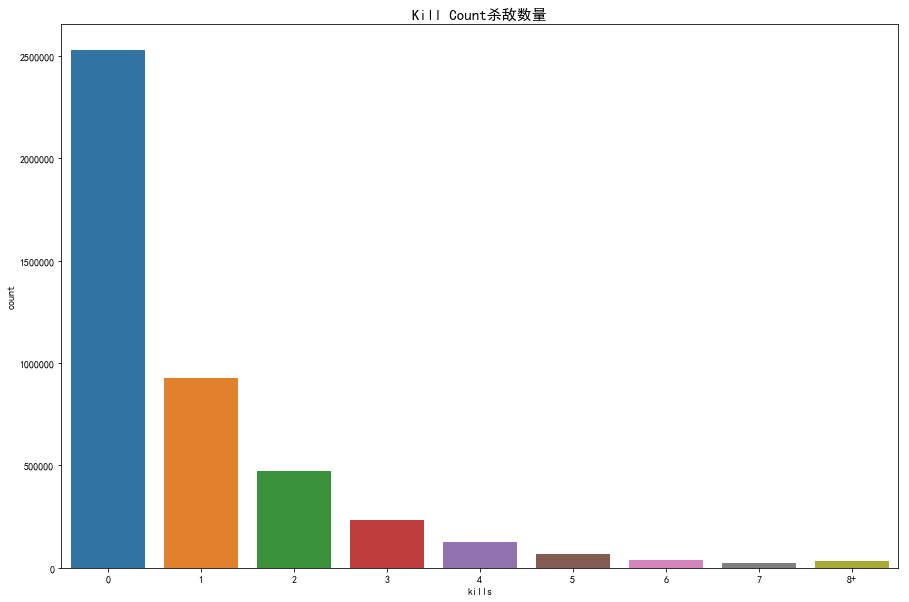

In [7]:
data = train.copy()
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,10))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count杀敌数量",fontsize=15)
plt.show()

大部分人甚至杀不了一个人，那么他们可以造成伤害吗？

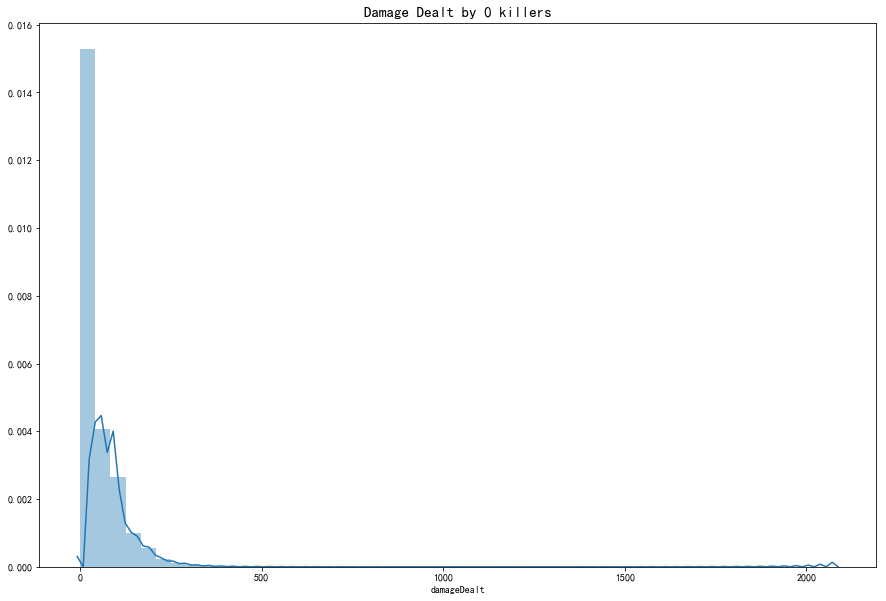

In [8]:
data = train.copy()
data = data[data['kills']==0]
plt.figure(figsize=(15,10))
plt.title("Damage Dealt by 0 killers",fontsize=15)
sns.distplot(data['damageDealt'])
plt.show()

好吧，大部分人甚至是零伤害的特约龙套。来看看别的情况情况

In [9]:
print("{} 名玩家 ({:.4f}%) 最终吃鸡但是没有杀一个人！".format(len(data[data['winPlacePerc']==1]), 100*len(data[data['winPlacePerc']==1])/len(train)))

data1 = train[train['damageDealt'] == 0].copy()
print("{} 名玩家 ({:.4f}%) 最终吃鸡但是没有造成伤害!".format(len(data1[data1['winPlacePerc']==1]), 100*len(data1[data1['winPlacePerc']==1])/len(train)))

16666 名玩家 (0.3748%) 最终吃鸡但是没有杀一个人！
4770 名玩家 (0.1073%) 最终吃鸡但是没有造成伤害!


看看最终排名跟杀敌个数的散点柱状图

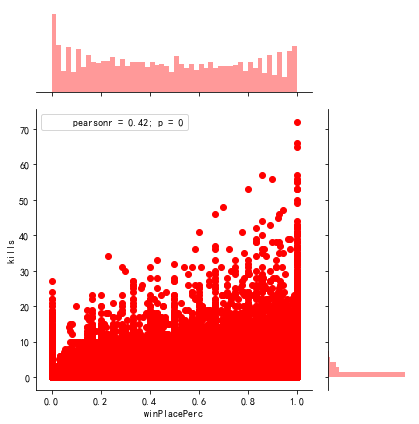

In [10]:
sns.jointplot(x="winPlacePerc", y="kills", data=train, ratio=3, color="r")
plt.show()

显然杀敌个数跟最终排名以及能否吃鸡是有关系的，最终我们将杀敌个数为0，1-2，3-5，6-10，10+的玩家归类看看

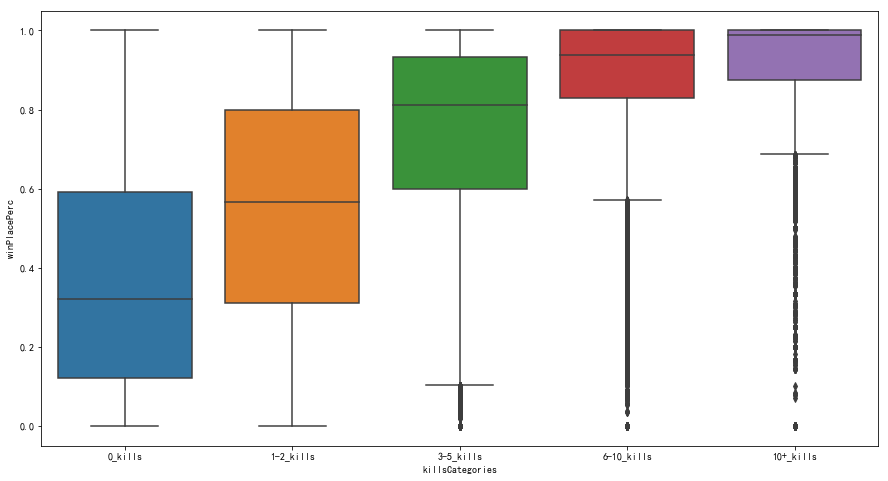

In [11]:
kills = train.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 60], labels=['0_kills','1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(15,8))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)
plt.show()

## The Runners

<img src="https://steemitimages.com/DQmRmYLRxu1vUhVtnFAA6bHFbShtr7Wdv1wLrPjdxbRZsjc/maxresdefault%20(2).jpg" alt="The Runners" style="width: 700px;"/>

In [12]:
print("平均每个人行走了 {:.1f}m, 99% 的玩家走了 {}m 或者更少, 马拉松运动员（步行距离最长的）走了 {}m.".format(train['walkDistance'].mean(), train['walkDistance'].quantile(0.99), train['walkDistance'].max()))

平均每个人行走了 1154.2m, 99% 的玩家走了 4396.0m 或者更少, 马拉松运动员（步行距离最长的）走了 25780.0m.


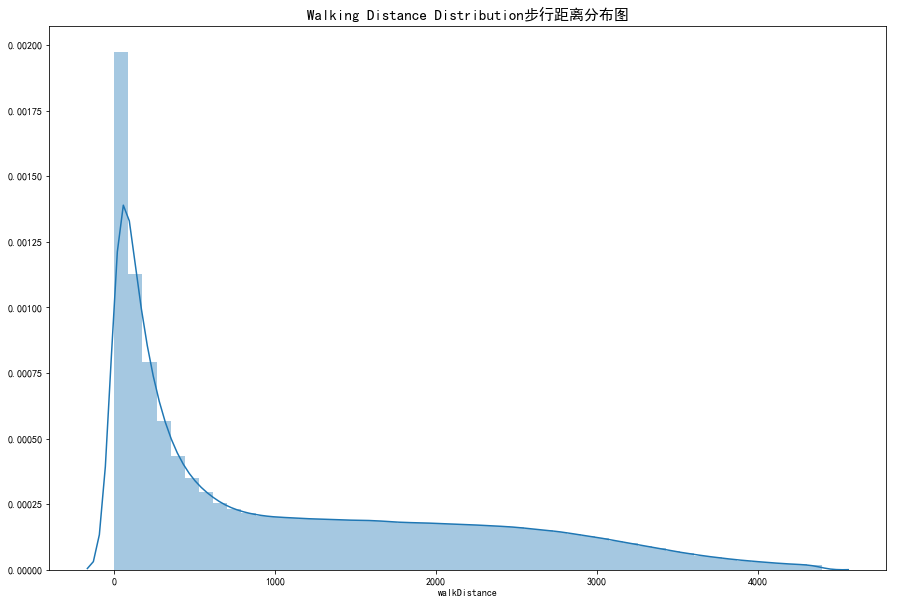

In [13]:
data = train.copy()
data = data[data['walkDistance'] < train['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title("Walking Distance Distribution步行距离分布图",fontsize=15)
sns.distplot(data['walkDistance'])
plt.show()

In [14]:
print("{} 的玩家 ({:.4f}%) 移动了0米. 意味着这些玩家落地成盒或者挂机（可能）.".format(len(data[data['walkDistance'] == 0]), 100*len(data1[data1['walkDistance']==0])/len(train)))

99603 的玩家 (2.0329%) 移动了0米. 意味着这些玩家落地成盒或者挂机（可能）.


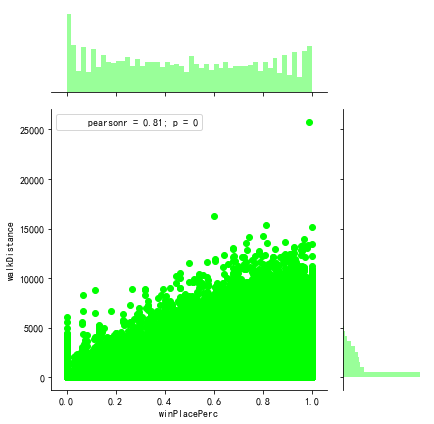

In [15]:
sns.jointplot(x="winPlacePerc", y="walkDistance",  data=train, ratio=3, color="lime")
plt.show()

显然行走距离跟最终排名也有很大联系

## The Drivers

<img src="http://cdn.gamer-network.net/2018/metabomb/pubghowtodrivecarsandbikes.jpg" alt="The Drivers" style="width: 700px;"/>

In [16]:
print("平均每个玩家驾驶 {:.1f}m, 99% 的玩家驾驶车辆行驶 {}m 或者更少, 驾驶车辆行驶里程最高的玩家走了 {}m.".format(train['rideDistance'].mean(), train['rideDistance'].quantile(0.99), train['rideDistance'].max()))

平均每个玩家驾驶 606.1m, 99% 的玩家驾驶车辆行驶 6966.0m 或者更少, 驾驶车辆行驶里程最高的玩家走了 40710.0m.


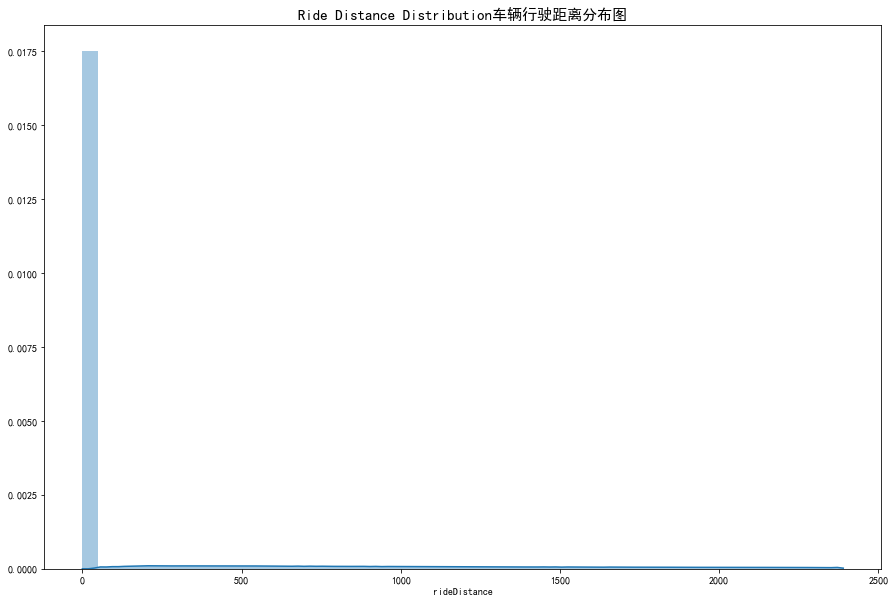

In [17]:
data = train.copy()
data = data[data['rideDistance'] < train['rideDistance'].quantile(0.9)]
plt.figure(figsize=(15,10))
plt.title("Ride Distance Distribution车辆行驶距离分布图",fontsize=15)
sns.distplot(data['rideDistance'])
plt.show()

In [18]:
print("{} 名玩家 ({:.4f}%) 开车行驶了0米. 可能意味着他们没有驾驶证23333.".format(len(data[data['rideDistance'] == 0]), 100*len(data1[data1['rideDistance']==0])/len(train)))

3309429 名玩家 (23.1022%) 开车行驶了0米. 可能意味着他们没有驾驶证23333.


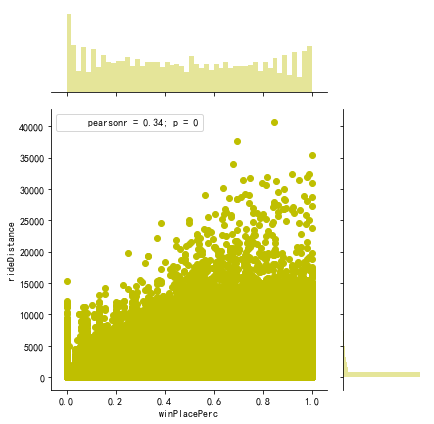

In [19]:
sns.jointplot(x="winPlacePerc", y="rideDistance", data=train, ratio=3, color="y")
plt.show()

车辆行驶里程跟最终排名没多大关系

按照经验来说，摧毁车辆意味着能杀敌，是不是这样呢？

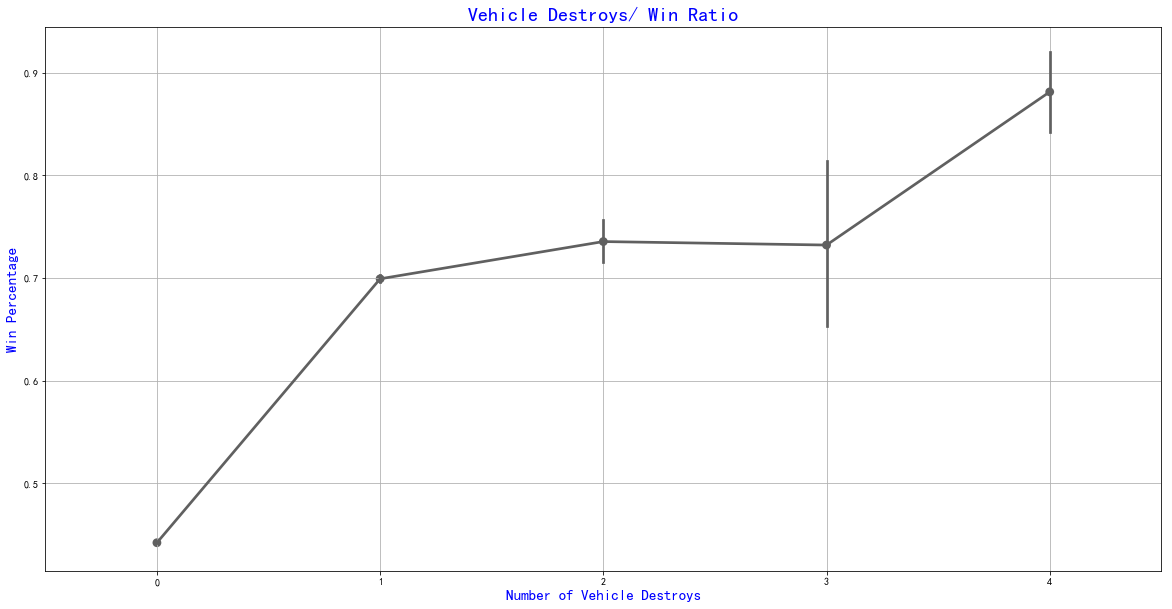

In [20]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='vehicleDestroys',y='winPlacePerc',data=data,color='#606060',alpha=0.8)
plt.xlabel('Number of Vehicle Destroys',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Vehicle Destroys/ Win Ratio',fontsize = 20,color='blue')
plt.grid()
plt.show()

看来我的经验是对的，摧毁一辆车能提高你获胜的几率！

## The Swimmers

<img src="https://i.ytimg.com/vi/tQxzsE0DijQ/maxresdefault.jpg" alt="The Swimmers" style="width: 700px;"/>

In [21]:
print("平均每个人游泳了 {:.1f}m, 99% 的玩家游了 {}m 或者更少, 游泳冠军游了 {}m.".format(train['swimDistance'].mean(), train['swimDistance'].quantile(0.99), train['swimDistance'].max()))

平均每个人游泳了 4.5m, 99% 的玩家游了 123.0m 或者更少, 游泳冠军游了 3823.0m.


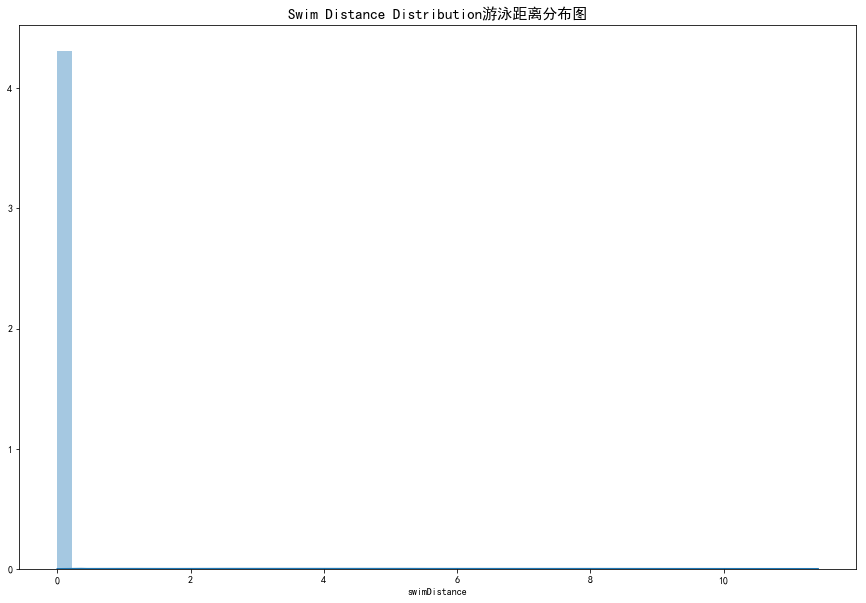

In [22]:
data = train.copy()
data = data[data['swimDistance'] < train['swimDistance'].quantile(0.95)]
plt.figure(figsize=(15,10))
plt.title("Swim Distance Distribution游泳距离分布图",fontsize=15)
sns.distplot(data['swimDistance'])
plt.show()

基本没有人游泳，试着将游泳距离分成四个类别来跟最终排名比较

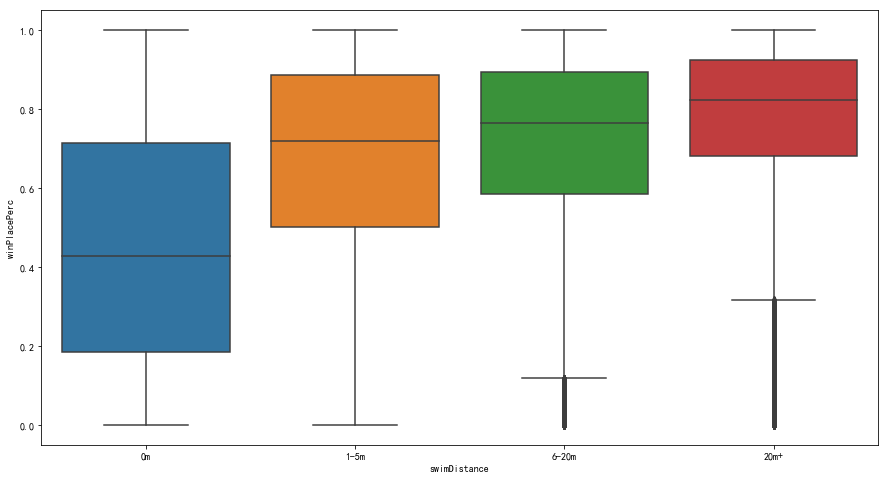

In [23]:
swim = train.copy()

swim['swimDistance'] = pd.cut(swim['swimDistance'], [-1, 0, 5, 20, 5286], labels=['0m','1-5m', '6-20m', '20m+'])

plt.figure(figsize=(15,8))
sns.boxplot(x="swimDistance", y="winPlacePerc", data=swim)
plt.show()

看起来好像只要你游泳了就能得到比较好的排名。但是在PUBG中有3个地图，其中沙漠地图是没有水的。按照这么看，应该需要根据地图来分类进行统计

## The Healers

<img src="https://i.ytimg.com/vi/xfI9XljX51k/maxresdefault.jpg" alt="The Healers" style="width: 700px;"/>

In [24]:
print("平均每个人用 {:.1f} 个治疗物品, 99% 的玩家用了 {} 个或者更少, 医疗兵用了 {}个.".format(train['heals'].mean(), train['heals'].quantile(0.99), train['heals'].max()))
print("平均每个人用 {:.1f} 个加速物品, 99% 的玩家用了 {} 个或者更少, 医疗兵用了 {}个.".format(train['boosts'].mean(), train['boosts'].quantile(0.99), train['boosts'].max()))

平均每个人用 1.4 个治疗物品, 99% 的玩家用了 12.0 个或者更少, 医疗兵用了 80个.
平均每个人用 1.1 个加速物品, 99% 的玩家用了 7.0 个或者更少, 医疗兵用了 33个.


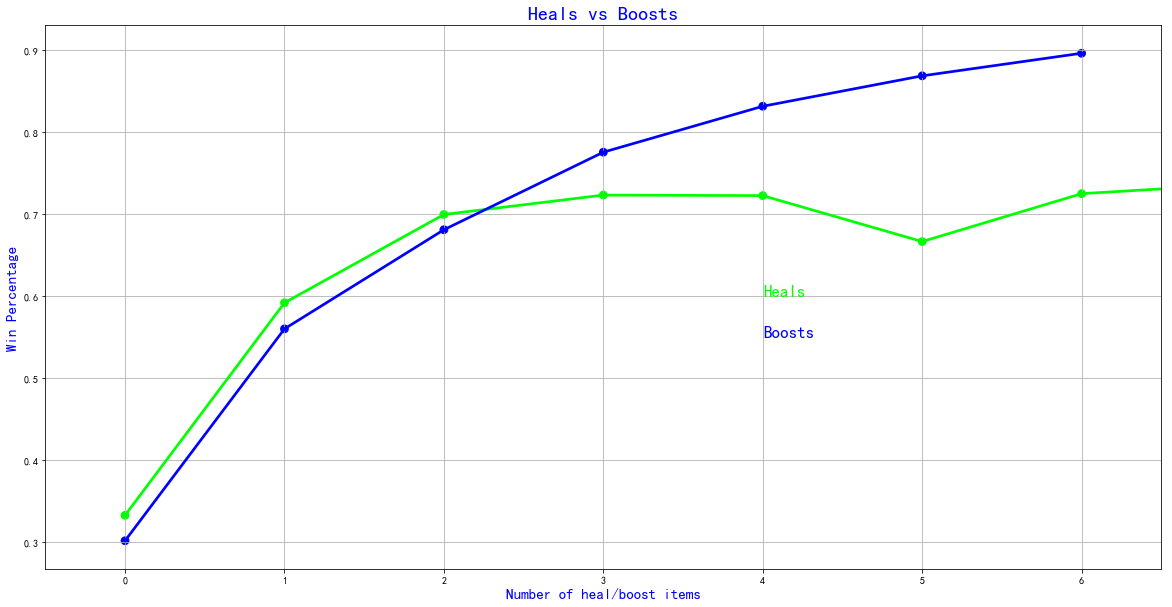

In [27]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='lime',alpha=0.8)
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='blue',alpha=0.8)
plt.text(4,0.6,'Heals',color='lime',fontsize = 17,style = 'italic')
plt.text(4,0.55,'Boosts',color='blue',fontsize = 17,style = 'italic')
plt.xlabel('Number of heal/boost items',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Heals vs Boosts',fontsize = 20,color='blue')
plt.grid()
plt.show()

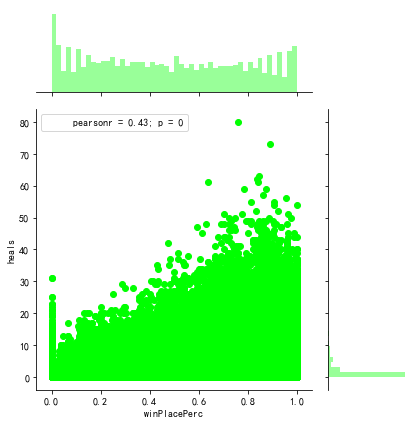

In [28]:
sns.jointplot(x="winPlacePerc", y="heals", data=train, ratio=3, color="lime")
plt.show()

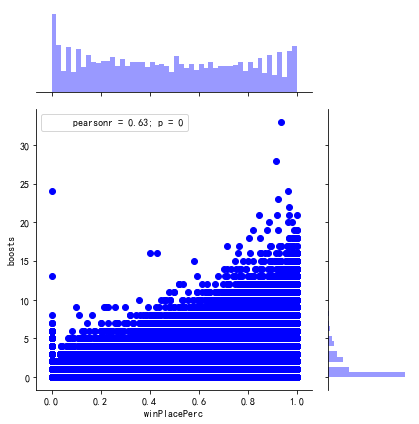

In [29]:
sns.jointplot(x="winPlacePerc", y="boosts", data=train, ratio=3, color="blue")
plt.show()

可以看出治疗物品跟加速物品的使用对最终排名是由联系的，显然加速物品的联系更大

在每个图中，都有值为0的异常行为

## Solos, Duos and Squads

有3种游戏模式，单人，双人以及四人，100名玩家参与游戏，因为在四人模式中最大队伍数量为25，双人模式中最大队伍数量为50

In [30]:
solos = train[train['numGroups']>50]
duos = train[(train['numGroups']>25) & (train['numGroups']<=50)]
squads = train[train['numGroups']<=25]
print("有 {} ({:.2f}%) 盘单人游戏, {} ({:.2f}%) 盘双人游戏以及 {} ({:.2f}%) 盘四人游戏.".format(len(solos), 100*len(solos)/len(train), len(duos), 100*len(duos)/len(train), len(squads), 100*len(squads)/len(train),))

有 709111 (15.95%) 盘单人游戏, 3295326 (74.10%) 盘双人游戏以及 442529 (9.95%) 盘四人游戏.


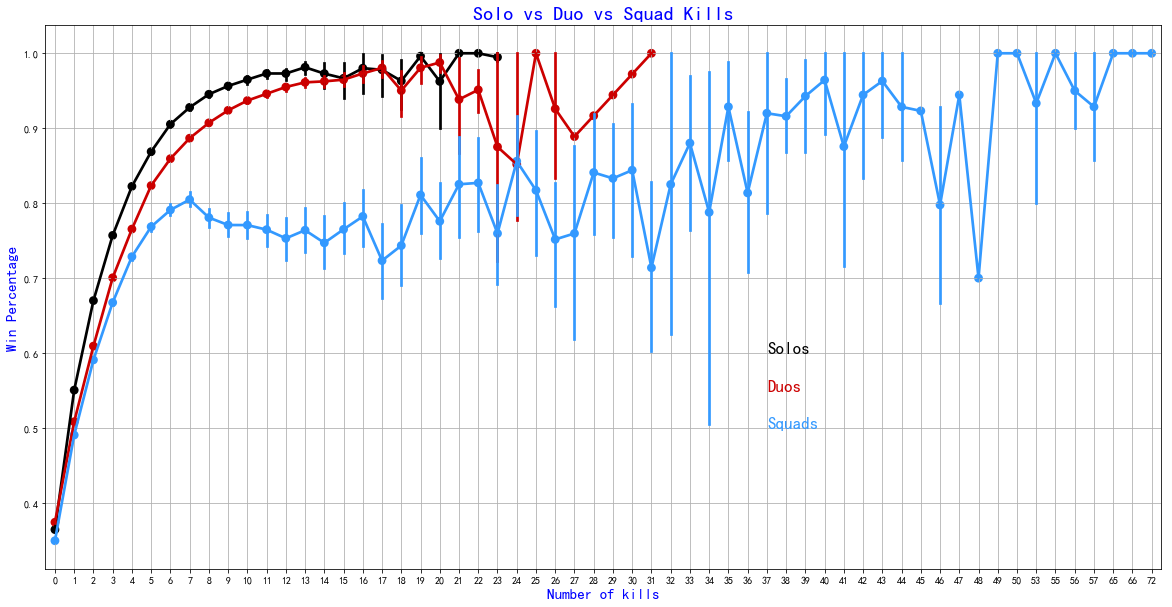

In [31]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='kills',y='winPlacePerc',data=solos,color='black',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=duos,color='#CC0000',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=squads,color='#3399FF',alpha=0.8)
plt.text(37,0.6,'Solos',color='black',fontsize = 17,style = 'italic')
plt.text(37,0.55,'Duos',color='#CC0000',fontsize = 17,style = 'italic')
plt.text(37,0.5,'Squads',color='#3399FF',fontsize = 17,style = 'italic')
plt.xlabel('Number of kills',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Solo vs Duo vs Squad Kills',fontsize = 20,color='blue')
plt.grid()
plt.show()

非常有趣的是，单人以及双人模式中杀敌越多排名越高，但是四人模式中却没有多大联系

特征DBNO是击倒敌人的数量，但是击倒只能在双人模式或者四人模式中发生，因为队友在限定时间内可以扶起被击倒的玩家。所以被击倒的玩家有死亡或者复活两种情况，如果他被复活了，那么他下次被击倒时，他的队友将会有更少的时间来扶起他。

特征助攻也只能在双人模式或者四人模式中发生，也就是说玩家帮助队友击倒敌人并造成了伤害。

特征复活也只能在双人模式或者四人模式中发生

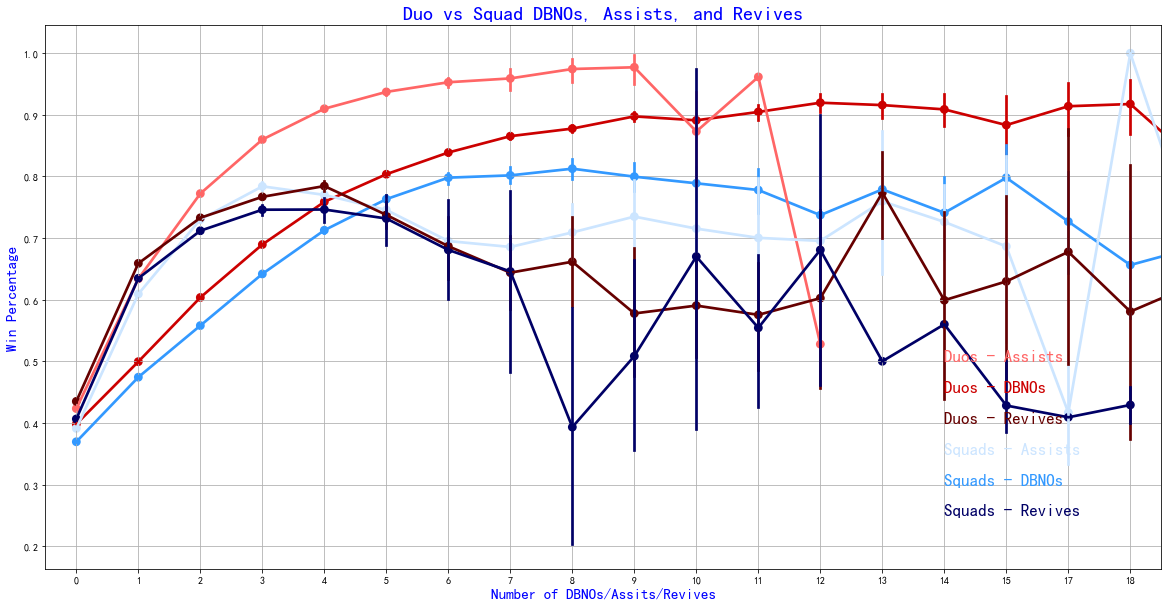

In [32]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='DBNOs',y='winPlacePerc',data=duos,color='#CC0000',alpha=0.8)
sns.pointplot(x='DBNOs',y='winPlacePerc',data=squads,color='#3399FF',alpha=0.8)
sns.pointplot(x='assists',y='winPlacePerc',data=duos,color='#FF6666',alpha=0.8)
sns.pointplot(x='assists',y='winPlacePerc',data=squads,color='#CCE5FF',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=duos,color='#660000',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=squads,color='#000066',alpha=0.8)
plt.text(14,0.5,'Duos - Assists',color='#FF6666',fontsize = 17,style = 'italic')
plt.text(14,0.45,'Duos - DBNOs',color='#CC0000',fontsize = 17,style = 'italic')
plt.text(14,0.4,'Duos - Revives',color='#660000',fontsize = 17,style = 'italic')
plt.text(14,0.35,'Squads - Assists',color='#CCE5FF',fontsize = 17,style = 'italic')
plt.text(14,0.3,'Squads - DBNOs',color='#3399FF',fontsize = 17,style = 'italic')
plt.text(14,0.25,'Squads - Revives',color='#000066',fontsize = 17,style = 'italic')
plt.xlabel('Number of DBNOs/Assits/Revives',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Duo vs Squad DBNOs, Assists, and Revives',fontsize = 20,color='blue')
plt.grid()
plt.show()

## Pearson correlation between variables皮尔逊相关系数

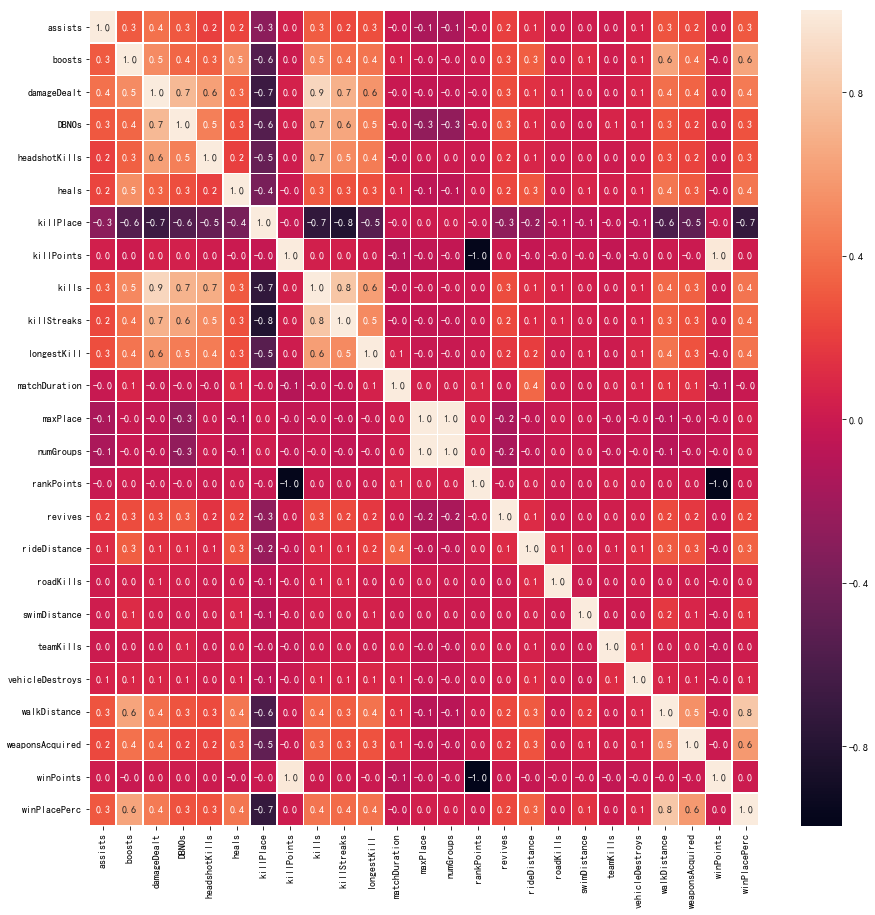

In [33]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

从目标变量winPlacePerc来看，只要少数变量与其有联系，联系最高的变量是walkDistance，联系最低的变量是killplace

**聚焦到5个与目标变量关系最密切的变量**

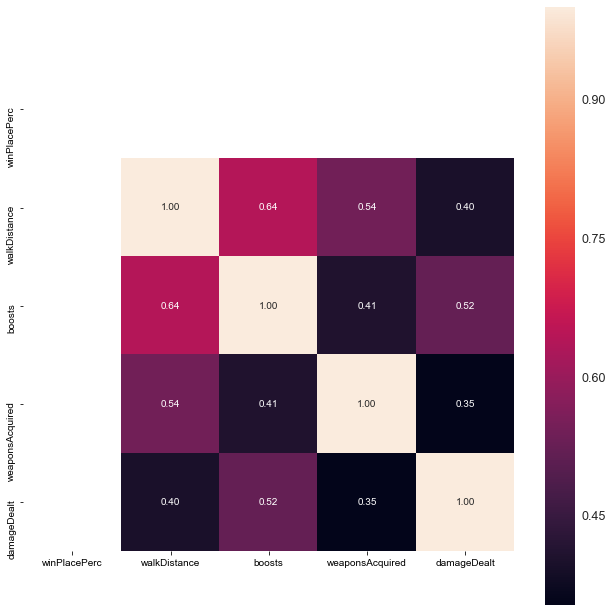

In [34]:
k = 5 #number of variables for heatmap
f,ax = plt.subplots(figsize=(11, 11))
cols = train.corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

看看上述5个变量以及killPlace的散点图矩阵

winPlacePerc       0
walkDistance       0
boosts             0
weaponsAcquired    0
damageDealt        0
killPlace          0
dtype: int64


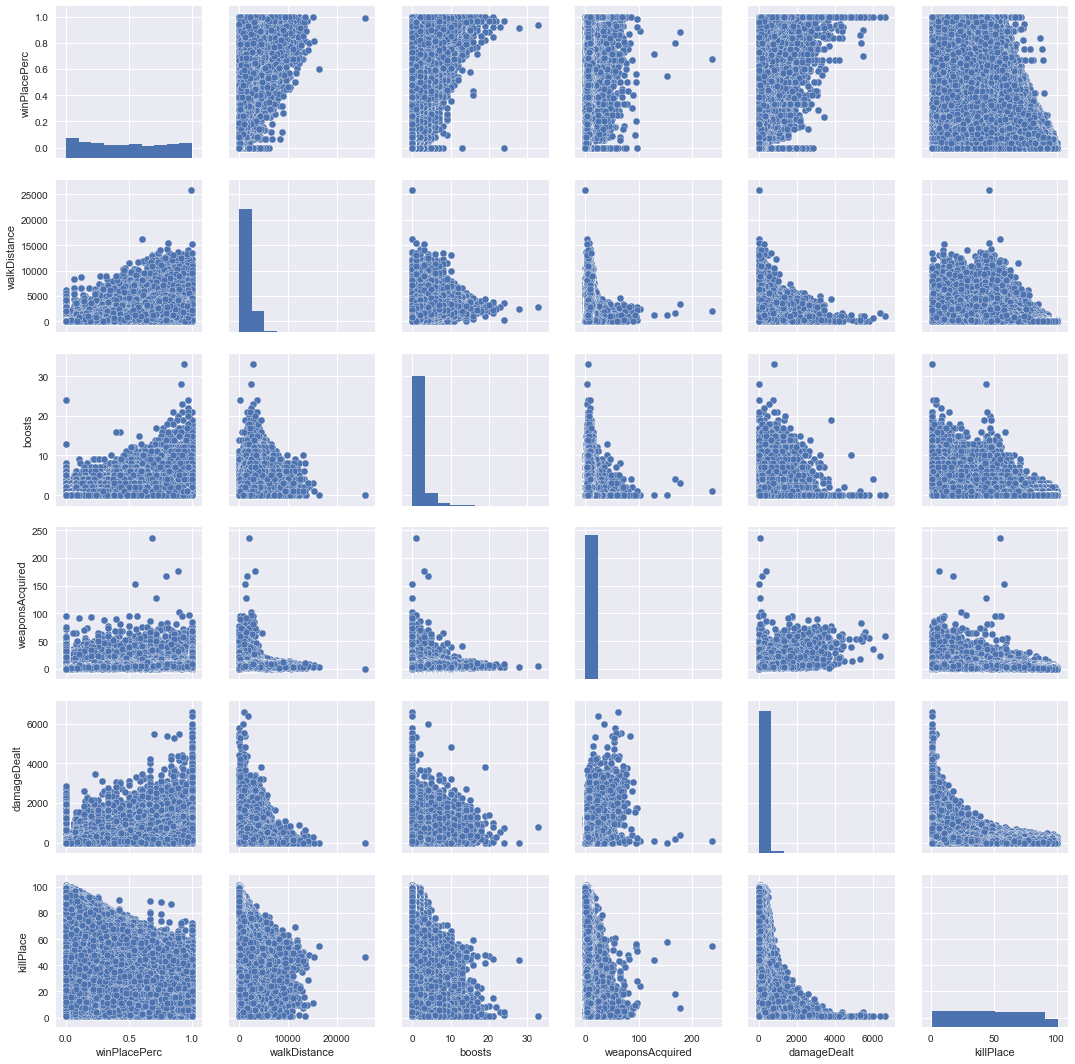

In [35]:
sns.set()
cols = ['winPlacePerc', 'walkDistance', 'boosts', 'weaponsAcquired', 'damageDealt', 'killPlace']
data = train[cols].dropna()
print(data.isnull().sum())
sns.pairplot(data, size = 2.5)
plt.show()

## Feature Engineering

一场游戏中能有最多100名玩家同场竞技。但是通常大部分游戏都不满人，但是没有变量告诉我们每场比赛中的实际参与玩家，那我们自己来创造一个

In [36]:
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')

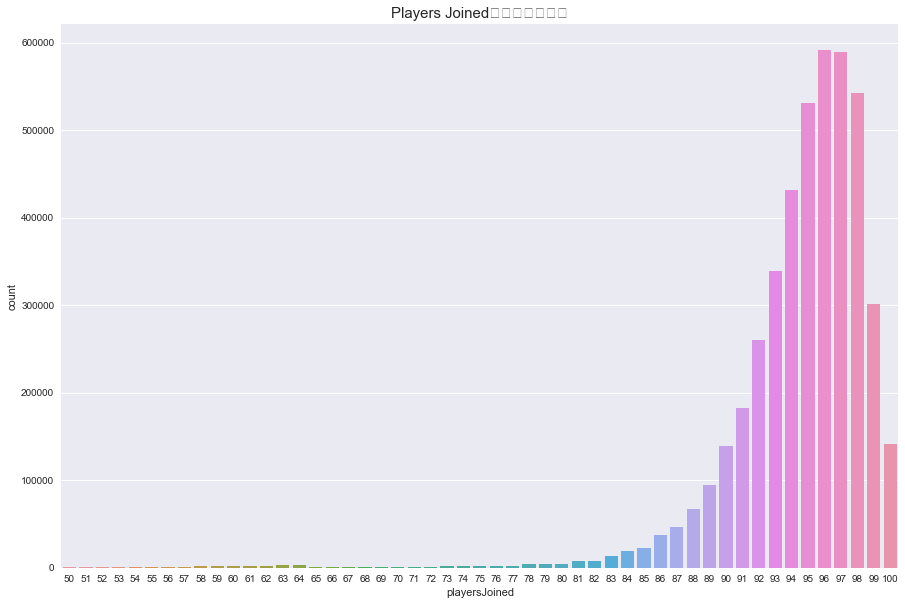

In [37]:
data = train.copy()
data = data[data['playersJoined']>49]
plt.figure(figsize=(15,10))
sns.countplot(data['playersJoined'])
plt.title("Players Joined实际参与玩家数",fontsize=15)
plt.show()

根据特征playersJoined（实际参与玩家数），可以构建一个杀敌评分标准以及伤害评分标准的特征，100名玩家的比赛肯定比90名玩家的比赛更容易找到敌人并杀敌，所以可以制定标准，100人比赛中每个杀敌可以获得1分，90人比赛中可以获得（100-90）/100 + 1=1.1分。当然这只是一个假设，也可以制定别的标准

In [38]:
train['killsNorm'] = train['kills']*((100-train['playersJoined'])/100 + 1)
train['damageDealtNorm'] = train['damageDealt']*((100-train['playersJoined'])/100 + 1)
train[['playersJoined', 'kills', 'killsNorm', 'damageDealt', 'damageDealtNorm']][5:8]

,playersJoined,kills,killsNorm,damageDealt,damageDealtNorm
5,95,1,1.05,100.000,105.00000
6,97,0,0.00,0.000,0.00000
7,96,0,0.00,8.538,8.87952


另一个简单的特征就是治疗以及加速药品的使用总量，还有总共移动的里程。

In [39]:
train['healsAndBoosts'] = train['heals']+train['boosts']
train['totalDistance'] = train['walkDistance']+train['rideDistance']+train['swimDistance']

当用了加速药品的时候，你会跑的更快，也会帮助你跑毒，逃离毒区，移动的距离也更长，所以需要构建一个特征boosts per walking distance（每移动1米所使用的加速药品）。治疗药品不会让你跑的更快，但是会让你在毒区停留更长的时间，所以也可以构建一个同样的特征heals per walking distance

In [40]:
train['boostsPerWalkDistance'] = train['boosts']/(train['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where boosts>0 and walkDistance=0. Strange.
train['boostsPerWalkDistance'].fillna(0, inplace=True)
train['healsPerWalkDistance'] = train['heals']/(train['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where heals>0 and walkDistance=0. Strange.
train['healsPerWalkDistance'].fillna(0, inplace=True)
train['healsAndBoostsPerWalkDistance'] = train['healsAndBoosts']/(train['walkDistance']+1) #The +1 is to avoid infinity.
train['healsAndBoostsPerWalkDistance'].fillna(0, inplace=True)
train[['walkDistance', 'boosts', 'boostsPerWalkDistance' ,'heals',  'healsPerWalkDistance', 'healsAndBoosts', 'healsAndBoostsPerWalkDistance']][40:45]

,walkDistance,boosts,boostsPerWalkDistance,heals,healsPerWalkDistance,healsAndBoosts,healsAndBoostsPerWalkDistance
40,327.30,1,0.003046,1,0.003046,2,0.006092
41,128.80,0,0.000000,0,0.000000,0,0.000000
42,52.52,0,0.000000,0,0.000000,0,0.000000
43,534.10,1,0.001869,0,0.000000,1,0.001869
44,2576.00,4,0.001552,6,0.002328,10,0.003880


同样的，也可以构建一个每公里杀敌数"killsPerWalkDistance"的特征

In [41]:
train['killsPerWalkDistance'] = train['kills']/(train['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where kills>0 and walkDistance=0. Strange.
train['killsPerWalkDistance'].fillna(0, inplace=True)
train[['kills', 'walkDistance', 'rideDistance', 'killsPerWalkDistance', 'winPlacePerc']].sort_values(by='killsPerWalkDistance').tail(10)

,kills,walkDistance,rideDistance,killsPerWalkDistance,winPlacePerc
4115816,29,0.0,0.0,29.0,0.7500
3083358,30,0.0,0.0,30.0,0.7500
422093,30,0.0,0.0,30.0,1.0000
2394021,31,0.0,0.0,31.0,0.5385
3057746,31,0.0,0.0,31.0,0.7500
2998470,35,0.0,0.0,35.0,1.0000
1158891,36,0.0,0.0,36.0,0.5833
3062788,36,0.0,0.0,36.0,0.8667
1068513,38,0.0,0.0,38.0,0.8333
1702541,43,0.0,0.0,43.0,1.0000


有人移动0米却杀敌数很高？通常这些人最终还会吃鸡，不用想了，肯定是开挂

前面我们对单人双人四人模式做了EDA，现在按组分类看看

In [42]:
train['team'] = [1 if i>50 else 2 if (i>25 & i<=50) else 4 for i in train['numGroups']]

In [43]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,playersJoined,killsNorm,damageDealtNorm,healsAndBoosts,totalDistance,boostsPerWalkDistance,healsPerWalkDistance,healsAndBoostsPerWalkDistance,killsPerWalkDistance,team
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,96,0.00,0.0000,0,244.8000,0.0,0.0,0.0,0.000000,2
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,91,0.00,99.7023,0,1445.0445,0.0,0.0,0.0,0.000000,4
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,98,0.00,69.3600,0,161.8000,0.0,0.0,0.0,0.000000,2
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,91,0.00,35.8610,0,202.7000,0.0,0.0,0.0,0.000000,2
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,97,1.03,103.0000,0,49.7500,0.0,0.0,0.0,0.019704,1


最终构建了10个特征，希望能在后续的预测中起作用！